In [64]:
import numpy as np
import xarray as xr
from xarray import broadcast
import seaborn as sns
from xgcm import Grid
from matplotlib import pyplot as plt
import dask
import dask.array as dsa
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean

%matplotlib inline

In [67]:
ds = xr.open_dataset('../outer_avg_01461.nc')
dds =xr.open_mfdataset('../ROMS_barra_huon_data/outer_avg_*.nc')
diag = xr.open_dataset('../outer_dia_01461.nc')

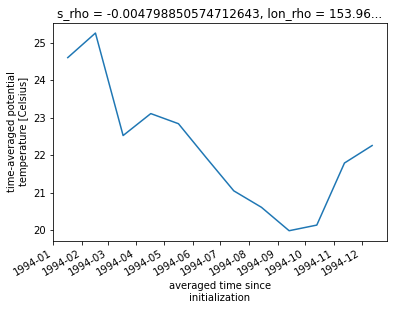

In [71]:
dds.temp.isel(eta_rho=150,xi_rho=150,s_rho=-1).plot()

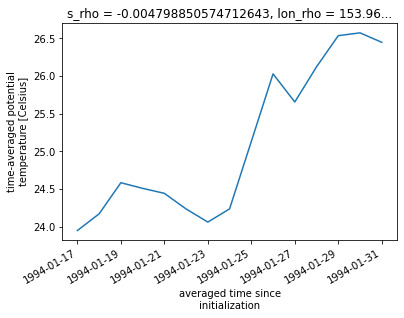

In [74]:
ds.temp.isel(eta_rho=150,xi_rho=150,s_rho=-1).sel(ocean_time=slice(dds.ocean_time[0],dds.ocean_time[-1])).plot()

## Creating a grid object
While xgcm doesn't currently have an implementation for the SGRID convention for ROMS, a workaround consist on renaming eta_u and xi_v dimensions to rho. With this replacement 'psi' points have now a position (eta_v, xi_u). See issue here https://github.com/xgcm/xgcm/issues/108
Here I also test to see if the new XGCM 'metrics' functionality works.

In [4]:
# Including metrics
ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}}

grid = Grid(ds, coords=coords, periodic=[])

Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho = Zo_rho * (ds.zeta + ds.h) + ds.zeta
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w = Zo_w * (ds.zeta + ds.h) + ds.zeta

ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')


ds['pm_v'] = grid.interp(ds.pm, 'Y')
ds['pn_u'] = grid.interp(ds.pn, 'X')
ds['pm_u'] = grid.interp(ds.pm, 'X')
ds['pn_v'] = grid.interp(ds.pn, 'Y')
ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)

ds['dx'] = 1/ds.pm
ds['dx_u'] = 1/ds.pm_u
ds['dx_v'] = 1/ds.pm_v
ds['dx_psi'] = 1/ds.pm_psi

ds['dy'] = 1/ds.pn
ds['dy_u'] = 1/ds.pn_u
ds['dy_v'] = 1/ds.pn_v
ds['dy_psi'] = 1/ds.pn_psi

ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
ds['dz_u'] = grid.interp(ds.dz, 'X')
ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
ds['dz_v'] = grid.interp(ds.dz, 'Y')
ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

ds['dA'] = ds.dx * ds.dy

metrics = {
    ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
    ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
    ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
    ('X', 'Y'): ['dA'] # Areas
}
grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])

## Get location of shelf edge, interp H to cell faces for use later

In [5]:
h_shelf = ds.h.where(ds.h<1000)
h_U = grid.interp(ds.h,'X')
h_V = grid.interp(ds.h,'Y')

In [6]:
diag.temp_xadv

<xarray.DataArray 'temp_xadv' (ocean_time: 30, s_rho: 30, eta_rho: 317, xi_rho: 272)>
[77601600 values with dtype=float32]
Coordinates:
  * s_rho       (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
    lon_rho     (eta_rho, xi_rho) float64 ...
    lat_rho     (eta_rho, xi_rho) float64 ...
  * ocean_time  (ocean_time) datetime64[ns] 1994-01-02 1994-01-03 ... 1994-01-31
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    long_name:  time-averaged potential temperature, horizontal XI-advection ...
    units:      Celsius second-1
    time:       ocean_time
    grid:       grid
    location:   face
    field:      temp_xadv, scalar, series

## Calculate vertical integrals plot all terms on facet grid
and fix the ****ing land mask

In [35]:
diag['temp_xadv_bar'] = grid.integrate(diag.temp_xadv,'Z').where(ds.mask_rho>0)
diag['temp_xdiff_bar'] = grid.integrate(diag.temp_xdiff,'Z').where(ds.mask_rho>0)
diag['temp_yadv_bar'] = grid.integrate(diag.temp_yadv,'Z').where(ds.mask_rho>0)
diag['temp_ydiff_bar'] = grid.integrate(diag.temp_ydiff,'Z').where(ds.mask_rho>0)
diag['temp_vdiff_bar'] = grid.integrate(diag.temp_vdiff,'Z').where(ds.mask_rho>0)
diag['temp_rate_bar'] = grid.integrate(diag.temp_rate,'Z').where(ds.mask_rho>0)
diag['temp_hadv_bar'] = grid.integrate(diag.temp_hadv,'Z').where(ds.mask_rho>0)

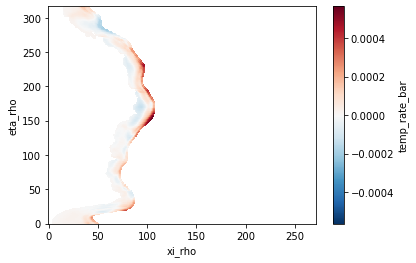

In [63]:
diag.temp_rate_bar.where(ds.h<1000).mean('ocean_time').plot()

/Users/neilmalan/miniconda3/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/Users/neilmalan/miniconda3/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/neilmalan/miniconda3/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/Users/neilmalan/miniconda3/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnin

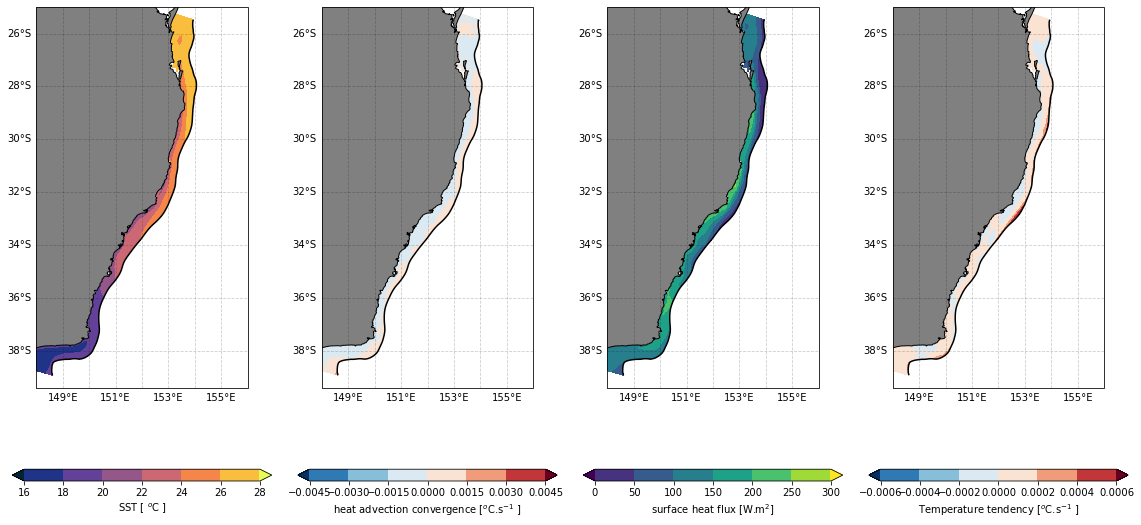

In [62]:
fig = plt.figure(figsize=(20,10))

latmin=25*-1
latmax=39.4*-1

#set up facet grid
grid = plt.GridSpec(1, 4, wspace=0.1, hspace=0.1)

#set coastline
coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='coastline')

#plot
ax = plt.subplot(grid[0, 0:1],projection=ccrs.PlateCarree())
feature = ax.add_feature(coast, edgecolor='black',facecolor='gray')
ax.set_extent([148,156,latmin,latmax])
ds.temp.isel(s_rho=-1).where(ds.h<1000).mean('ocean_time').plot.contourf('lon_rho', 'lat_rho', ax=ax,cmap=cmocean.cm.thermal,cbar_kwargs={'label': 'SST [ $^o$C ]','orientation': 'horizontal'},
                                          extend = 'both')
z = ds.h.plot.contour(x='lon_rho',y='lat_rho',colors='black',levels=[0,1000])
#make pretty gridlines and labels
gl = ax.gridlines(draw_labels=True,
             color='black', alpha=0.2, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabels_right = False
gl.xlabels_top = False

#plot
ax = plt.subplot(grid[0, 1:2],projection=ccrs.PlateCarree())
feature = ax.add_feature(coast, edgecolor='black',facecolor='gray')
ax.set_extent([148,156,latmin,latmax])
diag.temp_hadv_bar.where(ds.h<1000).mean('ocean_time').plot.contourf('lon_rho', 'lat_rho', ax=ax,cbar_kwargs={'label': 'heat advection convergence [$^o$C.s$^{-1}$ ]','orientation': 'horizontal'},
                                          extend = 'both')
z = ds.h.plot.contour(x='lon_rho',y='lat_rho',colors='black',levels=[0,1000])
#make pretty gridlines and labels
gl = ax.gridlines(draw_labels=True,
             color='black', alpha=0.2, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabels_right = False
gl.xlabels_top = False

#plot
ax = plt.subplot(grid[0, 2:3],projection=ccrs.PlateCarree())
feature = ax.add_feature(coast, edgecolor='black',facecolor='gray')
ax.set_extent([148,156,latmin,latmax])
ds.shflux.where(ds.h<1000).mean('ocean_time').plot.contourf('lon_rho', 'lat_rho', ax=ax,cbar_kwargs={'label': 'surface heat flux [W.m$^2$]','orientation': 'horizontal'},
                                          extend = 'both')
z = ds.h.plot.contour(x='lon_rho',y='lat_rho',colors='black',levels=[0,1000])
#make pretty gridlines and labels
gl = ax.gridlines(draw_labels=True,
             color='black', alpha=0.2, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabels_right = False
gl.xlabels_top = False

#plot
ax = plt.subplot(grid[0, 3:4],projection=ccrs.PlateCarree())
feature = ax.add_feature(coast, edgecolor='black',facecolor='gray')
ax.set_extent([148,156,latmin,latmax])
diag.temp_rate_bar.where(ds.h<1000).mean('ocean_time').plot.contourf('lon_rho', 'lat_rho', ax=ax,cbar_kwargs={'label': 'Temperature tendency [$^o$C.s$^{-1}$ ]','orientation': 'horizontal'},
                                          extend = 'both')
z = ds.h.plot.contour(x='lon_rho',y='lat_rho',colors='black',levels=[0,1000])
#make pretty gridlines and labels
gl = ax.gridlines(draw_labels=True,
             color='black', alpha=0.2, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabels_right = False
gl.xlabels_top = False


### lets do a single row depth integrated heat balance

Text(71, 151, 'temp_tend')

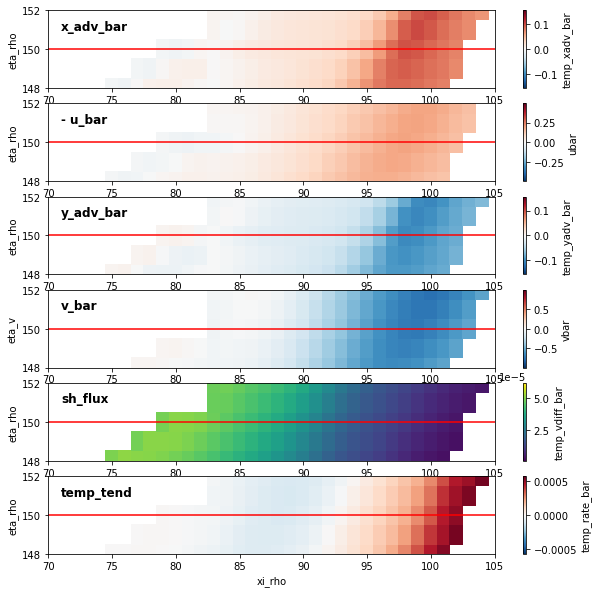

In [33]:
row = 150
plt.figure(figsize=(10, 10))
ax1 = plt.subplot(611)
# plot the bathymetry
diag.temp_xadv_bar.mean('ocean_time').where(ds.h<1000).plot()
plt.axhline(y = row, color = 'r', linestyle = '-')
plt.ylim(row-2,row+2)
plt.xlim(70,105)
plt.text(71,151,'x_adv_bar',transform=ax1.transData,size='large',weight='bold' )

ax2 = plt.subplot(612)
# plot the bathymetry
(ds.ubar.mean('ocean_time').where(h_U<1000)*-1).plot()
plt.axhline(y = row, color = 'r', linestyle = '-')
plt.ylim(row-2,row+2)
plt.xlim(70,105)
plt.text(71,151,'- u_bar',transform=ax2.transData,size='large',weight='bold' )

ax2 = plt.subplot(613)
# plot the bathymetry
diag.temp_yadv_bar.mean('ocean_time').where(ds.h<1000).plot()
plt.axhline(y = row, color = 'r', linestyle = '-')
plt.ylim(row-2,row+2)
plt.xlim(70,105)
plt.text(71,151,'y_adv_bar',transform=ax2.transData,size='large',weight='bold' )

ax2 = plt.subplot(614)
# plot the bathymetry
ds.vbar.mean('ocean_time').where(h_V<1000).plot()
plt.axhline(y = row, color = 'r', linestyle = '-')
plt.ylim(row-2,row+2)
plt.xlim(70,105)
plt.text(71,151,'v_bar',transform=ax2.transData,size='large',weight='bold' )

ax2 = plt.subplot(615)
# plot the bathymetry
diag.temp_vdiff_bar.mean('ocean_time').where(ds.h<1000).plot()
plt.axhline(y = row, color = 'r', linestyle = '-')
plt.ylim(row-2,row+2)
plt.xlim(70,105)
plt.text(71,151,'sh_flux',transform=ax2.transData,size='large',weight='bold' )

ax2 = plt.subplot(616)
# plot the bathymetry
diag.temp_rate_bar.mean('ocean_time').where(ds.h<1000).plot()
plt.axhline(y = row, color = 'r', linestyle = '-')
plt.ylim(row-2,row+2)
plt.xlim(70,105)
plt.text(71,151,'temp_tend',transform=ax2.transData,size='large',weight='bold' )

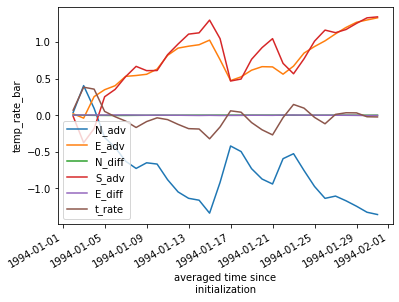

In [22]:
N_adv = diag.temp_yadv_bar.isel(eta_rho=row).sum('xi_rho')
S_adv = -diag.temp_yadv_bar.isel(eta_rho=row-1).sum('xi_rho')
E_adv = diag.temp_xadv_bar.isel(eta_rho=row).sum('xi_rho')
N_diff = diag.temp_ydiff_bar.isel(eta_rho=row).sum('xi_rho')
E_diff = diag.temp_xdiff_bar.isel(eta_rho=row).sum('xi_rho')
t_rate = diag.temp_rate_bar.isel(eta_rho=row).sum('xi_rho')
surf_flux = diag.temp_vdiff_bar.isel(eta_rho=row).sum('xi_rho')
tot_flux = N_adv + E_adv + N_diff + E_diff + surf_flux
N_adv.plot(label='N_adv')
E_adv.plot(label='E_adv')
N_diff.plot(label='N_diff')
S_adv.plot(label='S_adv')
E_diff.plot(label='E_diff')
t_rate.plot(label='t_rate')
#diag.temp_xadv_bar.isel(eta_rho=row,xi_rho=102).plot(label = 'Cross shelf')
plt.legend()


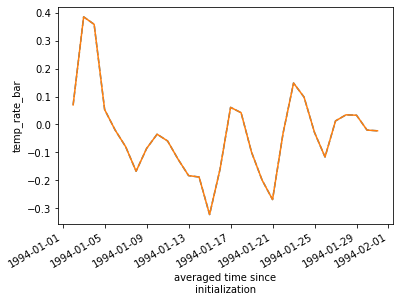

In [17]:
tot_flux.plot(linestyle='--')
t_rate.plot()

## This now doesn't balance - does the interpolation make that much difference?